In [30]:
#Setup
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from pathlib import Path
from enum import Enum

In [47]:

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Tensorflow needs to be version 2.7.0+ for full functionality!
print(tf.__version__)
# Activates code execution via graphics card. If no GPU is available, the CPU will be used
tf.config.list_physical_devices('GPU')
# Number of available GPU's on your device
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.7.0
Num GPUs Available:  1


In [32]:
# preset paths
# relative path is the project path, regardless of directory position
relative_project_path = str(Path.cwd())
path_training = relative_project_path + "\\food_training"
path_validation = relative_project_path + "\\food_validation"
path_training_pizza = path_training + "\pizza"
path_training_non_pizza = path_training + "\\non_pizza"
path_validation_pizza = path_validation + "\pizza"
path_validation_non_pizza = path_validation + "\\non_pizza"
#print(relative_project_path)
#print(path_pizza)
#print(path_non_pizza)

# Image classification like https://www.tensorflow.org/tutorials/images/classification
# image attributes
batch_size = 32
img_height = 220
img_width = 220
# train and validation seperate datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(path_training,validation_split=0.2,subset="training",seed=524,image_size=(img_height, img_width),batch_size=batch_size)
validation_dataset = tf.keras.utils.image_dataset_from_directory(path_validation,validation_split=0.2,subset="validation",seed=524,image_size=(img_height, img_width),batch_size=batch_size)

class_names = train_dataset.class_names
print(class_names)

Found 1600 files belonging to 2 classes.
Using 1280 files for training.
Found 1997 files belonging to 2 classes.
Using 399 files for validation.
['not_pizza', 'pizza']


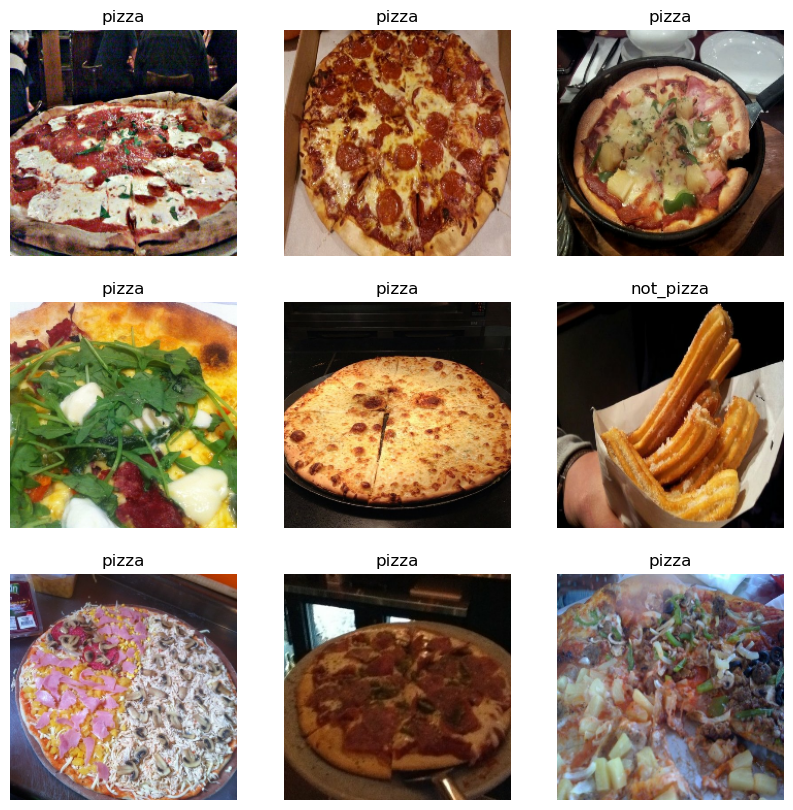

In [33]:
#Visualize the data
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

View the pictures

In [34]:
#Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [35]:
#Standardize the data
normalization_layer = layers.Rescaling(1./255)

In [36]:
normalized_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_dataset))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [37]:
#Create the model
num_classes = len(class_names)
Algorithm = Enum('Algorithm', 'deserialize elu exponential gelu hard_sigmoid linear relu selu sigmoid softplus softsign swish tanh')
activate = Algorithm.relu.name

#TODO: For better accuracy tweak the model
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation=activate),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation=activate),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation=activate),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation=activate),
  layers.Dense(num_classes)
])

#Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 220, 220, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 220, 220, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 110, 110, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 55, 55, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 55, 55, 64)       

In [39]:
#Train the model
epochs=100
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/100
40/40 [==============================] - 2s 42ms/step - loss: 0.8083 - accuracy: 0.5789 - val_loss: 0.7566 - val_accuracy: 0.5890
Epoch 2/100
40/40 [==============================] - 1s 33ms/step - loss: 0.6215 - accuracy: 0.6547 - val_loss: 0.6226 - val_accuracy: 0.6692
Epoch 3/100
40/40 [==============================] - 1s 33ms/step - loss: 0.5339 - accuracy: 0.7492 - val_loss: 0.5000 - val_accuracy: 0.7920
Epoch 4/100
40/40 [==============================] - 1s 33ms/step - loss: 0.6025 - accuracy: 0.7227 - val_loss: 0.6722 - val_accuracy: 0.6742
Epoch 5/100
40/40 [==============================] - 1s 33ms/step - loss: 0.4627 - accuracy: 0.7930 - val_loss: 0.4298 - val_accuracy: 0.8095
Epoch 6/100
40/40 [==============================] - 1s 33ms/step - loss: 0.3596 - accuracy: 0.8422 - val_loss: 0.4314 - val_accuracy: 0.7970
Epoch 7/100
40/40 [==============================] - 1s 34ms/step - loss: 0.2801 - accuracy: 0.8867 - val_loss: 0.3746 - val_accuracy: 0.8596
Epoch 

View train results

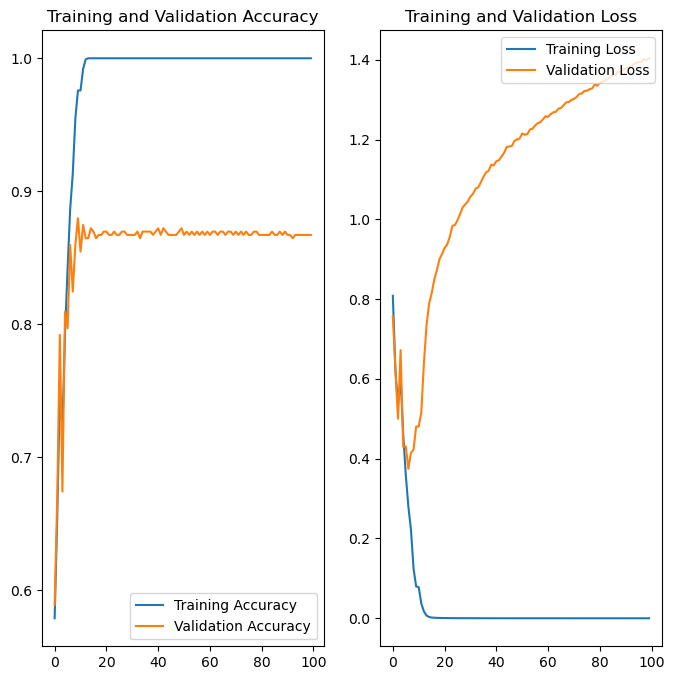

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [41]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(train_dataset)

In [42]:
# try the trustness of the model
np.argmax(predictions[67])

0

In [43]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

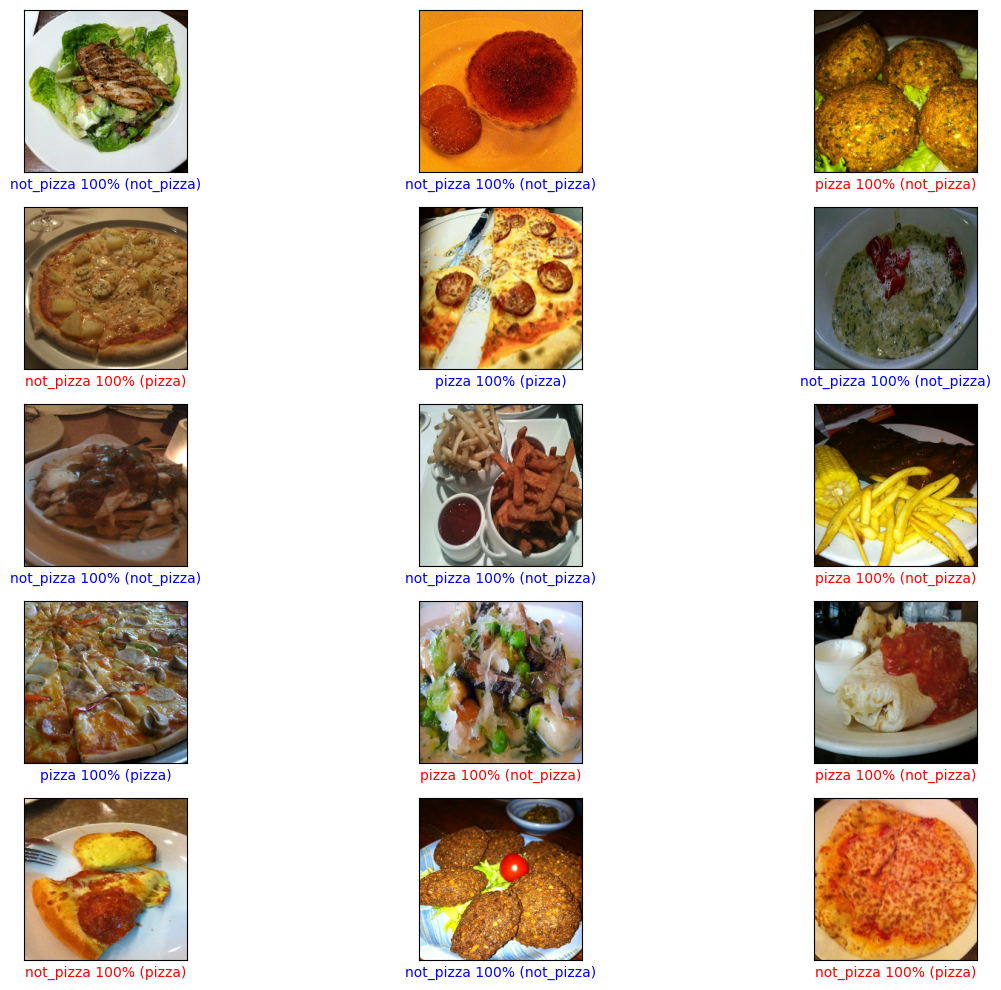

In [46]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  #print(i)
  #print(predictions[i])
  #print(labels_batch)
  #print(image_batch)
  plot_image(i, predictions[i], labels_batch, image_batch)
plt.tight_layout()
plt.show()

In [45]:
print('Very low accuracy,I guess the reason is that there are only two class called "pizza" and "non pizza".And there are too many possibilities in "non pizza" class!!!')




Very low accuracy,I guess the reason is that there are only two class called "pizza" and "non pizza".And there are too many possibilities in "non pizza" class!!!
